<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementation-of-the-mean-Average-Precision-(mAP)-at-different-intersection-over-union-(IoU)" data-toc-modified-id="Implementation-of-the-mean-Average-Precision-(mAP)-at-different-intersection-over-union-(IoU)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation of the mean Average Precision (mAP) at different intersection over union (IoU)</a></span></li><li><span><a href="#Load-Example" data-toc-modified-id="Load-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Example</a></span><ul class="toc-item"><li><span><a href="#Ground-truth" data-toc-modified-id="Ground-truth-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Ground truth</a></span></li><li><span><a href="#Simulated-prediction" data-toc-modified-id="Simulated-prediction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Simulated prediction</a></span></li></ul></li><li><span><a href="#Metric" data-toc-modified-id="Metric-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metric</a></span><ul class="toc-item"><li><span><a href="#IoU" data-toc-modified-id="IoU-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>IoU</a></span></li><li><span><a href="#Precision" data-toc-modified-id="Precision-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Precision</a></span></li><li><span><a href="#Overall-Metric" data-toc-modified-id="Overall-Metric-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Overall Metric</a></span><ul class="toc-item"><li><span><a href="#IoU" data-toc-modified-id="IoU-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>IoU</a></span></li></ul></li><li><span><a href="#Compute" data-toc-modified-id="Compute-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Compute</a></span></li></ul></li><li><span><a href="#Calculate-for-validation-set" data-toc-modified-id="Calculate-for-validation-set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate for validation set</a></span></li></ul></div>

# Implementation of the mean Average Precision (mAP) at different intersection over union (IoU)

As described [here](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation)

Code adapted from [here](https://www.kaggle.com/wcukierski/example-metric-implementation) (please upvote this kernel as well), as the metric should be the same as the 2018 DSB one.

- FIX v4 : Removed background from the analysis
- EDIT v5 : Metric should be computed at image level, I updated comments regarding this.
- EDIT v6, v7 : Variables `false_negatives` and `false_positives` were inverted (?).

In [1]:
import os
import skimage
import numpy as np
import pandas as pd
import skimage.segmentation
import matplotlib.pyplot as plt

# Load Example

In [68]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

In [3]:
df = pd.read_csv('dataset/train.csv')
df = df.groupby('id').agg(list).reset_index()

for col in df.columns[2:]:
    df[col] = df[col].apply(
        lambda x: np.unique(x)[0] if len(np.unique(x)) == 1 else np.unique(x)
    )

## Ground truth

In [4]:
i = 0  # feel free to change that

shape = df[['height', 'width']].values[i]

rles = df['annotation'][i]

masks = rles_to_mask(rles, shape).astype(np.uint16)

/tmp/ipykernel_7629/1788212983.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


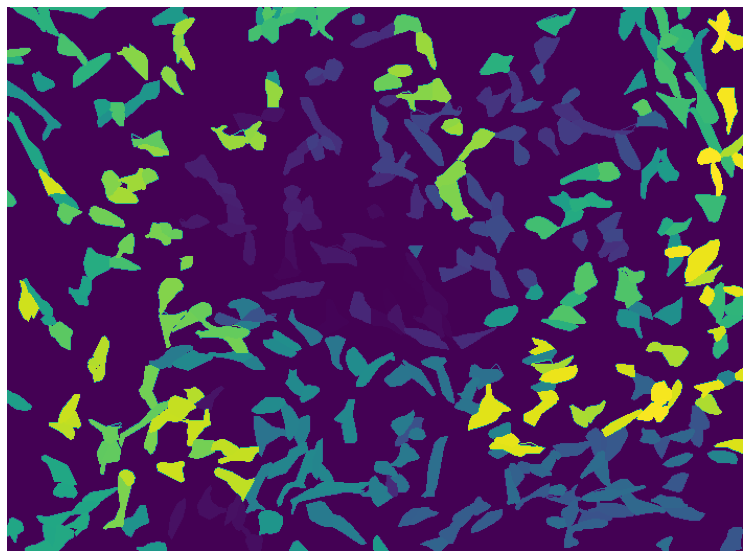

In [5]:
plt.figure(figsize=(15, 10))
plt.imshow(masks)
plt.axis(False)
plt.show()

## Simulated prediction

In [6]:
# offset pixels
offset = 1
y_pred = masks[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")

# Remove a bunch of cells
y_pred[y_pred > 300] = 0 

# Relabel objects
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) 

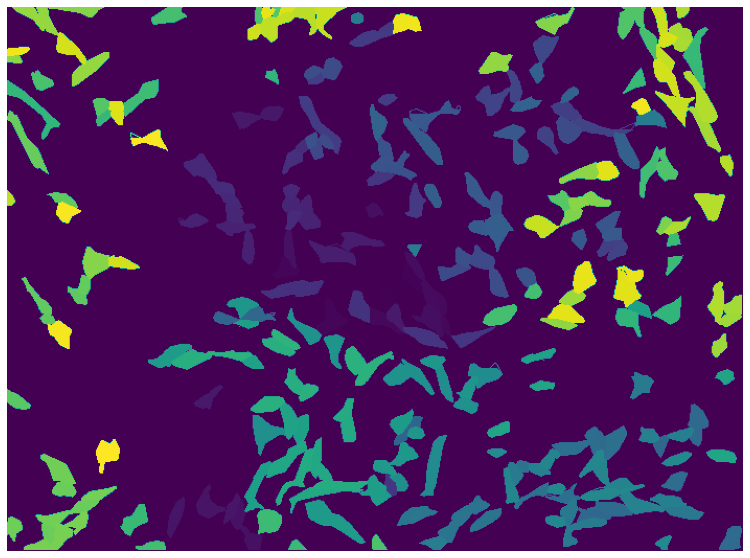

In [7]:
plt.figure(figsize=(15, 10))
plt.imshow(y_pred)
plt.axis(False)
plt.show()

# Metric

## IoU

In [8]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

## Precision

In [9]:
def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

## Overall Metric

### IoU

In [10]:
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]
    
    print(ious[0].shape)

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

## Compute

In [11]:
iou_map([masks] * 5, [masks] * 5, verbose=1)  # This should score 1

(395, 395)
Thresh	TP	FP	FN	Prec.
0.500	1975	0	0	1.000
0.550	1975	0	0	1.000
0.600	1975	0	0	1.000
0.650	1975	0	0	1.000
0.700	1975	0	0	1.000
0.750	1975	0	0	1.000
0.800	1975	0	0	1.000
0.850	1975	0	0	1.000
0.900	1975	0	0	1.000
0.950	1975	0	0	1.000
AP	-	-	-	1.000


1.0

In [12]:
iou_map([masks] , [y_pred], verbose=1)

(395, 300)
Thresh	TP	FP	FN	Prec.
0.500	300	0	95	0.759
0.550	300	0	95	0.759
0.600	300	0	95	0.759
0.650	293	7	102	0.729
0.700	266	34	129	0.620
0.750	196	104	199	0.393
0.800	110	190	285	0.188
0.850	35	265	360	0.053
0.900	3	297	392	0.004
0.950	0	300	395	0.000
AP	-	-	-	0.427


0.42655686764202655

# Calculate for validation set

In [55]:
train_df = pd.read_csv("dataset/train.csv")
shape = train_df[['height', 'width']].values[0]

In [56]:
prediction_df = pd.read_csv("eval/experiment_cyto_diameter20/submission.csv")

In [57]:
train_df = train_df.groupby('id').agg(list).reset_index()
prediction_df = prediction_df.groupby('id').agg(list).reset_index()

In [58]:
train_df[["id", "annotation"]].head()

,id,annotation
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 ...
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 360...
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 ...
3,026b3c2c4b32,[170753 5 171454 12 172158 13 172862 13 173565...
4,029e5b3b89c7,[139142 7 139845 10 140548 13 141251 15 141955...


In [59]:
prediction_df.head()

,id,predicted
0,01ae5a43a2ab,[62 12 763 17 1465 20 2169 21 2873 22 3577 23 ...
1,026b3c2c4b32,[5802 1 6503 8 7206 11 7910 12 8614 13 9318 13...
2,0728b8f39241,[18291 6 18994 9 19697 12 20400 14 21104 15 21...
3,07e9ba109e34,[57 8 760 10 1463 11 2167 10 2870 11 3573 12 4...
4,0c5938ac5e3c,[100 12 803 14 1507 14 2211 14 2915 14 3619 14...


In [72]:
iou_list = []
for i, row in prediction_df.iterrows():
    #print(row.id)
    annot = train_df[train_df["id"] == row.id].annotation.values[0]
    pred = row.predicted
    ann = rles_to_mask(annot, shape)
    pred = rles_to_mask(pred, shape)
    #print(val_ann.shape, val_pred.shape)
    iou_list.append(iou_map([ann] , [pred], verbose=1))
    #fig, ax = plt.subplots(2)
    #ax[0].imshow(val_ann)
    #ax[1].imshow(val_pred)
    #plt.show()
iou_array = np.array(iou_list)

/tmp/ipykernel_7629/1788212983.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(enc, np.float) and np.isnan(enc):


(36, 33)
Thresh	TP	FP	FN	Prec.
0.500	32	1	4	0.865
0.550	32	1	4	0.865
0.600	32	1	4	0.865
0.650	30	3	6	0.769
0.700	29	4	7	0.725
0.750	27	6	9	0.643
0.800	19	14	17	0.380
0.850	7	26	29	0.113
0.900	1	32	35	0.015
0.950	0	33	36	0.000
AP	-	-	-	0.524
(42, 33)
Thresh	TP	FP	FN	Prec.
0.500	31	2	11	0.705
0.550	26	7	16	0.531
0.600	26	7	16	0.531
0.650	25	8	17	0.500
0.700	24	9	18	0.471
0.750	19	14	23	0.339
0.800	14	19	28	0.230
0.850	6	27	36	0.087
0.900	0	33	42	0.000
0.950	0	33	42	0.000
AP	-	-	-	0.339
(32, 27)
Thresh	TP	FP	FN	Prec.
0.500	27	0	5	0.844
0.550	26	1	6	0.788
0.600	25	2	7	0.735
0.650	25	2	7	0.735
0.700	22	5	10	0.595
0.750	20	7	12	0.513
0.800	18	9	14	0.439
0.850	14	13	18	0.311
0.900	5	22	27	0.093
0.950	0	27	32	0.000
AP	-	-	-	0.505
(421, 331)
Thresh	TP	FP	FN	Prec.
0.500	267	64	154	0.551
0.550	250	81	171	0.498
0.600	227	104	194	0.432
0.650	182	149	239	0.319
0.700	124	207	297	0.197
0.750	65	266	356	0.095
0.800	16	315	405	0.022
0.850	5	326	416	0.007
0.900	0	331	421	0.000
0.950	0	331	421	0.000
AP	-	

(76, 33)
Thresh	TP	FP	FN	Prec.
0.500	24	9	52	0.282
0.550	19	14	57	0.211
0.600	19	14	57	0.211
0.650	17	16	59	0.185
0.700	15	18	61	0.160
0.750	11	22	65	0.112
0.800	2	31	74	0.019
0.850	0	33	76	0.000
0.900	0	33	76	0.000
0.950	0	33	76	0.000
AP	-	-	-	0.118
(79, 44)
Thresh	TP	FP	FN	Prec.
0.500	38	6	41	0.447
0.550	36	8	43	0.414
0.600	32	12	47	0.352
0.650	24	20	55	0.242
0.700	13	31	66	0.118
0.750	6	38	73	0.051
0.800	2	42	77	0.017
0.850	0	44	79	0.000
0.900	0	44	79	0.000
0.950	0	44	79	0.000
AP	-	-	-	0.164
(27, 26)
Thresh	TP	FP	FN	Prec.
0.500	13	13	14	0.325
0.550	13	13	14	0.325
0.600	11	15	16	0.262
0.650	8	18	19	0.178
0.700	6	20	21	0.128
0.750	3	23	24	0.060
0.800	1	25	26	0.019
0.850	1	25	26	0.019
0.900	1	25	26	0.019
0.950	0	26	27	0.000
AP	-	-	-	0.134
(29, 25)
Thresh	TP	FP	FN	Prec.
0.500	19	6	10	0.543
0.550	19	6	10	0.543
0.600	19	6	10	0.543
0.650	18	7	11	0.500
0.700	15	10	14	0.385
0.750	13	12	16	0.317
0.800	7	18	22	0.149
0.850	1	24	28	0.019
0.900	0	25	29	0.000
0.950	0	25	29	0.000
AP	-	-	-	0.300
(25

In [73]:
print(iou_array.mean())

0.31134603045510506
